In [8]:
conda install keras

Solving environment: done

## Package Plan ##

  environment location: /Users/artemryzhkov/opt/anaconda3

  added / updated specs:
    - keras


The following NEW packages will be INSTALLED:

  keras              pkgs/main/osx-64::keras-2.3.1-0
  keras-base         pkgs/main/osx-64::keras-base-2.3.1-py37_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda remove tensorflow

Solving environment: failed

PackagesNotFoundError: The following packages are missing from the target environment:
  - tensorflow



Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import pandas as pd
import numpy as np

In [ ]:
import os
import sys
from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request

In [ ]:
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense

In [ ]:
import shutil
import os

In [2]:
df = pd.read_csv('data.tsv', sep='\t')

In [3]:
df = df.iloc[:,0:2]

In [4]:
df

,INPUT:image,OUTPUT:result
0,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
1,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
2,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK
3,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK
4,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
...,...,...
19785,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
19786,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
19787,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK
19788,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK


In [5]:
df.rename(columns={'INPUT:image':'image', 'OUTPUT:result':'target'}, inplace=True)

In [6]:
df

,image,target
0,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
1,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
2,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK
3,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK
4,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
...,...,...
19785,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
19786,https://d27iguyig7r7wz.cloudfront.net/upload/s...,BAD
19787,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK
19788,https://d27iguyig7r7wz.cloudfront.net/upload/s...,OK


In [7]:
df_ok = df.loc[df['target'] == 'OK']

In [13]:
df_bad = df.loc[df['target'] == 'BAD']

In [28]:
### Create folders with image classifier

In [10]:
df_ok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4626 entries, 2 to 19788
Data columns (total 2 columns):
image     4626 non-null object
target    4626 non-null object
dtypes: object(2)
memory usage: 108.4+ KB


In [14]:
for image in range(5500):
    with urllib.request.urlopen(df_bad.iloc[image, 0]) as url:
        with open('/Users/image_BAD{}.jpg'.format(image), 'wb') as f:
            f.write(url.read())

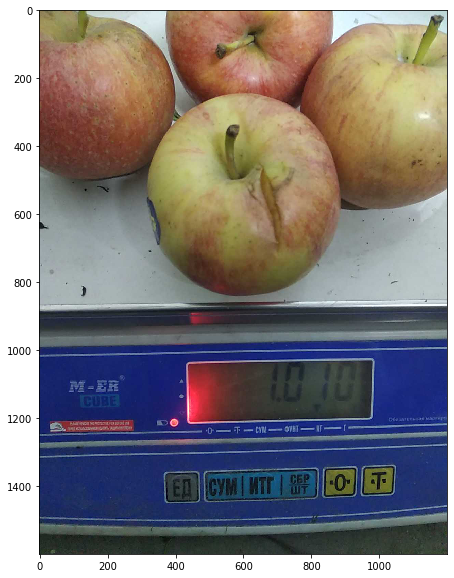

In [17]:
image = imread('/Users/image_OK5.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [1]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 7600
# Количество изображений для проверки
nb_validation_samples = 1300
# Количество изображений для тестирования
nb_test_samples = 1300

In [1]:
# Каталог с набором данных
data_dir = '/Users/'
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Часть набора данных для тестирования
test_data_portion = 0.12
# Часть набора данных для проверки
val_data_portion = 0.12
# Количество элементов данных в одном классе
nb_images = 4500

In [2]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, "ok"))
    os.makedirs(os.path.join(dir_name, "bad"))

In [5]:
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

In [6]:
def copy_images(start_index, end_index, source_dir, dest_dir):
    for i in range(start_index, end_index):
        try:
            shutil.copy2(os.path.join(source_dir, "image_OK" + str(i) + ".jpg"), 
                        os.path.join(dest_dir, "ok"))
            shutil.copy2(os.path.join(source_dir, "image_BAD" + str(i) + ".jpg"), 
                       os.path.join(dest_dir, "bad"))
        except:
            continue

In [7]:
start_val_data_idx = int(nb_images * (1 - val_data_portion - test_data_portion))
start_test_data_idx = int(nb_images * (1 - test_data_portion))
print(start_val_data_idx)
print(start_test_data_idx)

3420
3960


In [8]:
copy_images(0, start_val_data_idx, data_dir, train_dir)
copy_images(start_val_data_idx, start_test_data_idx, data_dir, val_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

In [32]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 9000
# Количество изображений для проверки
nb_validation_samples = 1000
# Количество изображений для тестирования
nb_test_samples = 1000

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [38]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 6213 images belonging to 2 classes.


In [39]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1312 images belonging to 2 classes.


In [40]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1144 images belonging to 2 classes.


In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/30


In [14]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)

In [15]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 95.49%


In [48]:
model.save("cv_model.h5")

In [56]:
model.save_weights('cv_model_weights.h5')

In [57]:
import numpy as np
from PIL import Image
from keras.preprocessing import image
img = image.load_img('/Users/image_OK13.jpg') # , target_size=(32,32))
img  = image.img_to_array(img)
img  = img.reshape((1,) + img.shape)

Using TensorFlow backend.


In [1]:
img = image.load_img('/Users/OK2.jpg', target_size=(150,150))
img  = image.img_to_array(img)
img  = img.reshape((1,) + img.shape)
img  = img/255
predict = model.predict_classes(img)

NameError: name 'image' is not defined

In [89]:
def test_():
    from skimage.io import imread
    for i in files:
        img = image.load_img('/Users/qwe/{}'.format(i), target_size=(150,150))
        images = imread(img)
        plt.figure(figsize=(10, 10))
        plt.imshow(images)
        plt.show()
        img  = image.img_to_array(img)
        img  = img.reshape((1,) + img.shape)
        img  = img/255
        answer = model.predict_classes(img)
        if answer == 1:
            print("Весы есть")
        else:
            print("Весов нет")